In [13]:
import torch
import random
import collections
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import numpy as np
import skimage
import pickle
from cv2 import PSNR
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified


In [56]:
class SineLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, is_first=False, is_last=False, omega=30):
        super().__init__()
        self.omega = omega
        self.linear = torch.nn.Linear(in_features, out_features)
        self.linear.bias.data.fill_(0.0)
        self.is_last = is_last
        with torch.no_grad():
            if is_first:
                self.linear.weight.uniform_(-1 / in_features, 1 / in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / in_features) / omega, np.sqrt(6 / in_features) / omega)

    def forward(self, x):
        if self.is_last:
            return self.linear(x)
        return torch.sin(self.omega * self.linear(x))


class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, last_linear=True, omega=30):
        super().__init__()
        self.net = [SineLayer(in_features, hidden_features, is_first=True)]
        self.net += [SineLayer(hidden_features, hidden_features) for i in range(hidden_layers)]
        self.last_linear = last_linear
        if last_linear:
            linear = torch.nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                linear.weight.uniform_(-np.sqrt(6 / hidden_features) / omega, np.sqrt(6 / hidden_features) / omega)
            self.net.append(linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features))
        self.net = torch.nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords

In [57]:
class Functa(Dataset):
    def __init__(self, img, side_length, in_dim=2, out_dim=3):
        super().__init__()
        transform = transforms.Compose([transforms.Resize(side_length),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5] * out_dim, [0.5] * out_dim)])
        img = transform(img)
        self.img = img
        self.shape = img.shape[1:]
        self.pixels = img.permute(1, 2, 0).view(-1, out_dim)
        tensors = tuple(torch.linspace(-1, 1, steps=l) for l in self.shape)
        self.shape = (*self.shape, out_dim)
        self.coords = torch.stack(torch.meshgrid(*tensors), dim=-1).reshape(-1, in_dim)

    def __getitem__(self, index):
        return self.coords, self.pixels

    def __len__(self):
        return 1

In [58]:
def train(siren, functa_loader, steps, summary_interval=50):
    optim = torch.optim.Adam(siren.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()
    coords, pixels = next(iter(functa_loader))
    coords, pixels = coords.to(device), pixels.to(device)
    for step in range(steps):
        logit, coords = siren(coords)
        loss = criterion(logit, pixels)
        optim.zero_grad()
        loss.backward()
        optim.step()
    print("Step {}, total loss {}".format(steps, loss.item()))
    generated = logit.cpu().view(functa_loader.dataset.shape).detach()
    print("PSNR: {}".format(PSNR(pixels.cpu().view(functa_loader.dataset.shape).numpy(), generated.numpy())))
    plt.imshow(generated.numpy() * 0.5 + 0.5)
    plt.show()
    return generated * 0.5 + 0.5

Step 100, total loss 0.024291330948472023
PSNR: 64.27629095868132


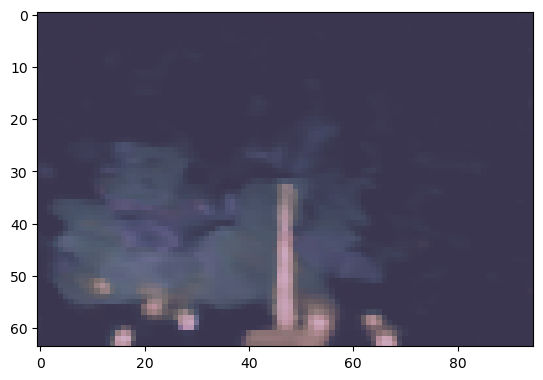

In [61]:
img = Image.fromarray(skimage.data.rocket())
fset = Functa(img, 64, out_dim=3)
fl = DataLoader(fset, batch_size=1, shuffle=False)
siren = Siren(2, 50, 10, 3).to(device)
generated = train(siren, fl, 100)

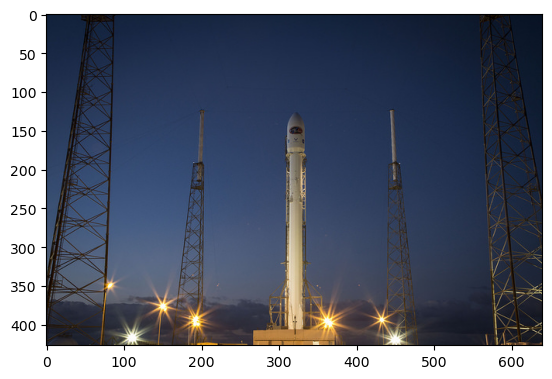

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.0001468767150072381
PSNR: 86.46127440281828


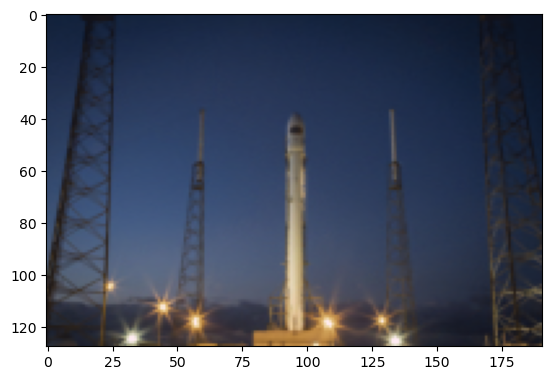

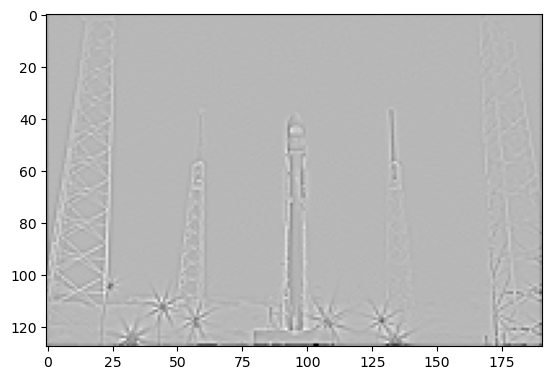

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


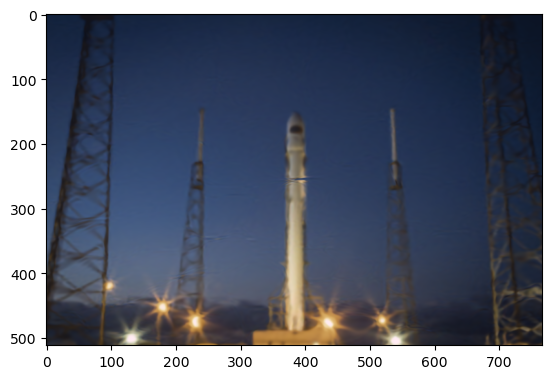

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


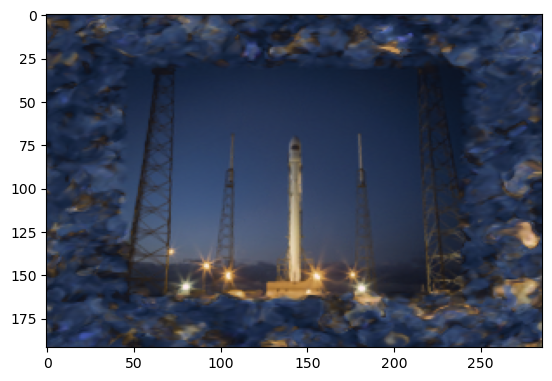

In [22]:
torch.manual_seed(42)
img = Image.fromarray(skimage.data.rocket())
plt.imshow(img)
plt.show()
fset = Functa(img, 128, out_dim=3)
fl = DataLoader(fset, batch_size=1, shuffle=False)
siren = Siren(2, 100, 15, 3).to(device)
generated = train(siren, fl, 1000)
laplace = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]]).float().view(1,1,3,3)
x = generated.permute(2,0,1).unsqueeze(0)
y = torch.nn.functional.conv2d(x, laplace.repeat(1, 3, 1, 1), stride=1, padding=1)
y = y.squeeze(0).permute(1,2,0).numpy()
plt.imshow(y, cmap='gray')
plt.show()
fnew = Functa(img, 512, out_dim=3)
flnew = DataLoader(fnew, batch_size=1, shuffle=False)
coords, _ = next(iter(flnew))
coords = coords.to(device)
siren.eval()
logit, coords = siren(coords)
generated = logit.cpu().view(flnew.dataset.shape).detach().numpy()
plt.imshow(generated * 0.5 + 0.5)
plt.show()
new_shape = (int(y.shape[0] * 1.5), int(y.shape[1] * 1.5))
tensors = tuple(torch.linspace(-1.5, 1.5, steps=l) for l in new_shape)
coords = torch.stack(torch.meshgrid(*tensors), dim=-1).reshape(-1, 2).to(device)
logit, coords = siren(coords)
generated = logit.cpu().view(*new_shape,3).detach().numpy()
plt.imshow(generated * 0.5 + 0.5)

Step 1000, total loss 0.006181914359331131
PSNR: 70.21957357791104


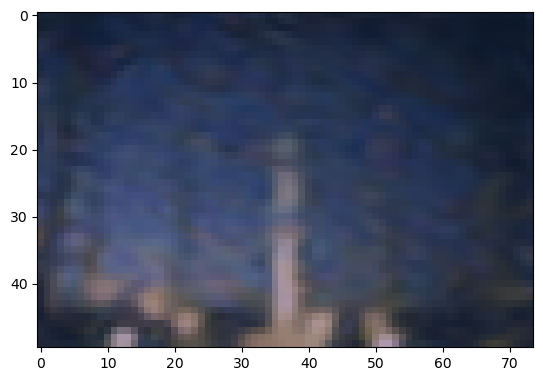

Step 1000, total loss 0.0006266399868763983
PSNR: 80.1606227425762


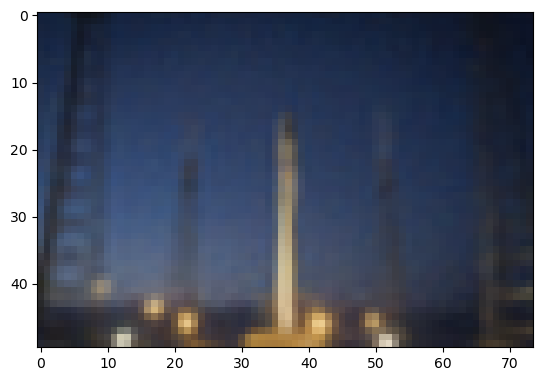

Step 1000, total loss 0.0001859867770690471
PSNR: 85.43598295184259


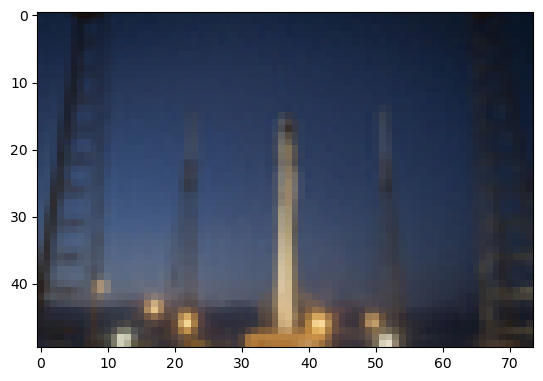

Step 1000, total loss 8.012742910068482e-05
PSNR: 89.09299187255917


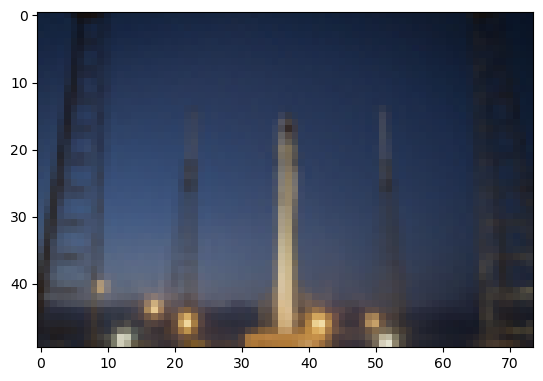

Step 1000, total loss 1.587108454259578e-05
PSNR: 96.12473761222246


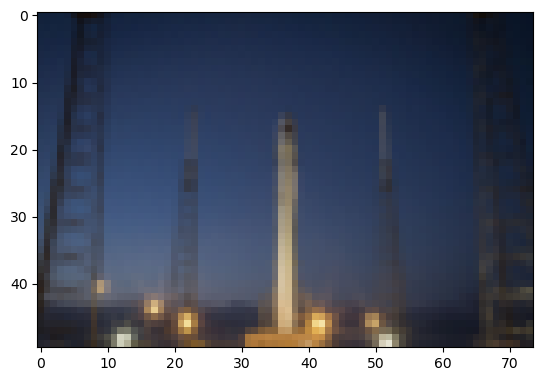

Step 1000, total loss 6.391551323758904e-06
PSNR: 100.07474107272196


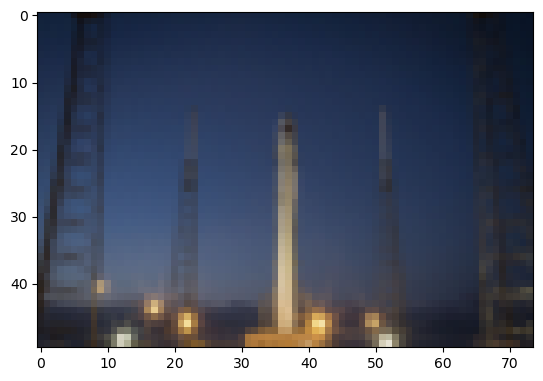

Step 1000, total loss 0.008687869645655155
PSNR: 68.7416710763848


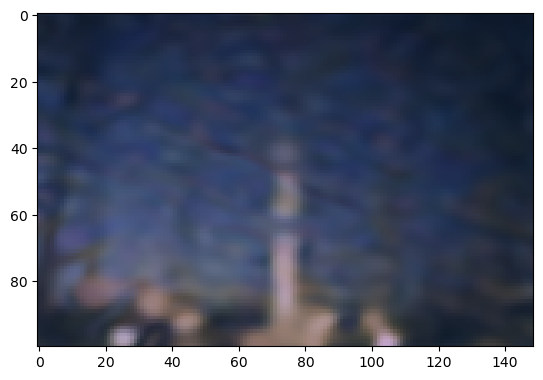

Step 1000, total loss 0.002065520966425538
PSNR: 74.98050758901537


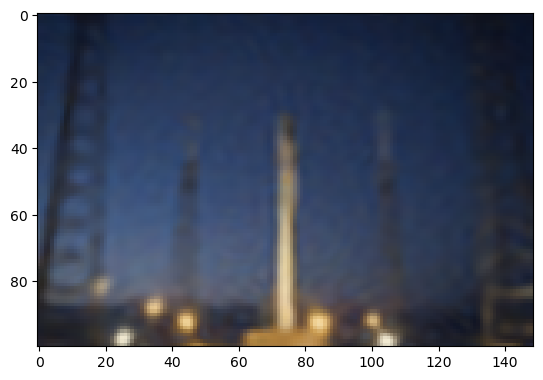

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.0009893475798889995
PSNR: 78.17731476301947


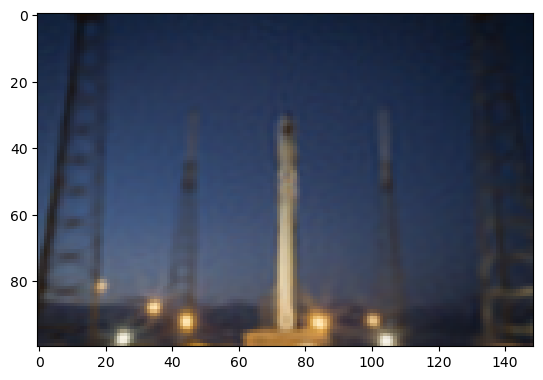

Step 1000, total loss 0.0005532469949685037
PSNR: 80.70161314059186


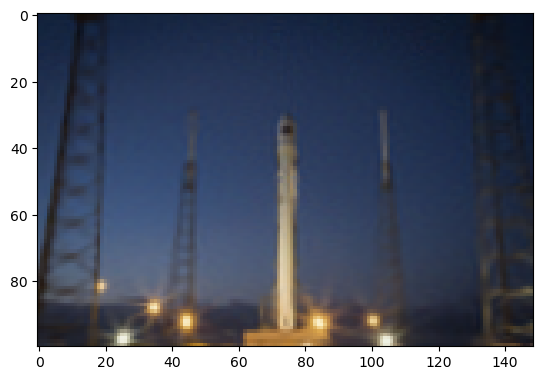

Step 1000, total loss 0.0003634786116890609
PSNR: 82.52601522298005


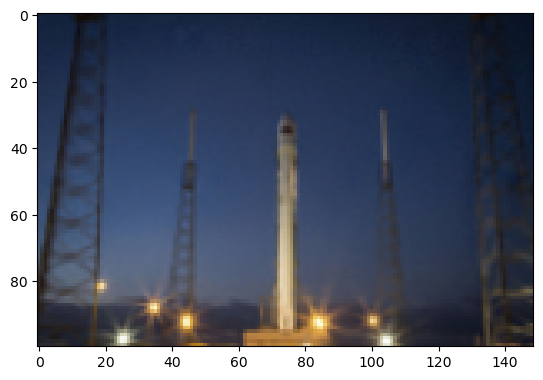

Step 1000, total loss 0.00011502605048008263
PSNR: 87.52284166625986


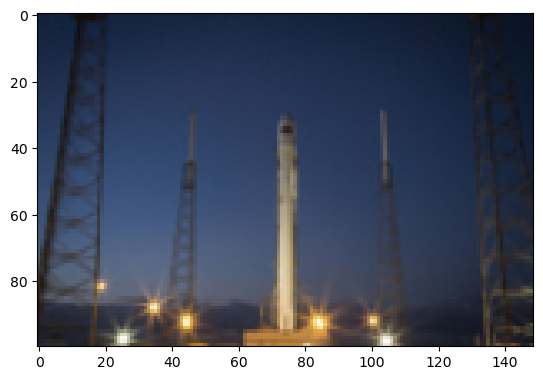

Step 1000, total loss 0.01144725363701582
PSNR: 67.54379066342312


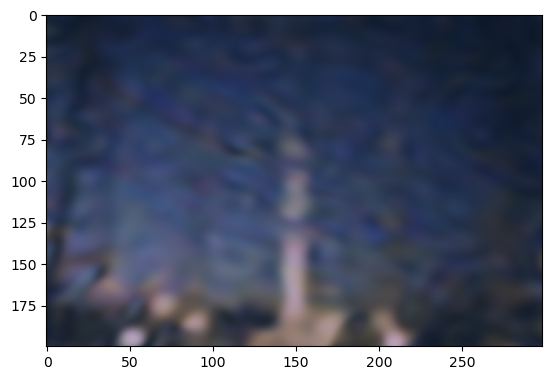

Step 1000, total loss 0.0044112177565693855
PSNR: 71.68521913813586


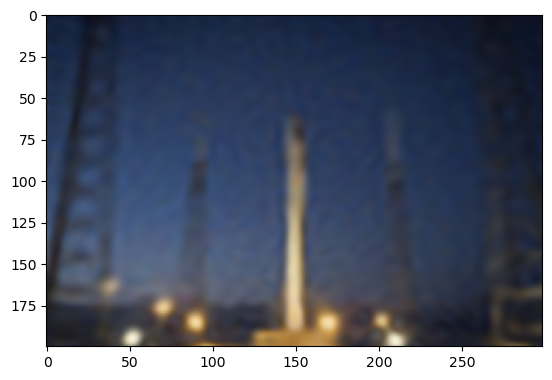

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.002912558149546385
PSNR: 73.48805800712222


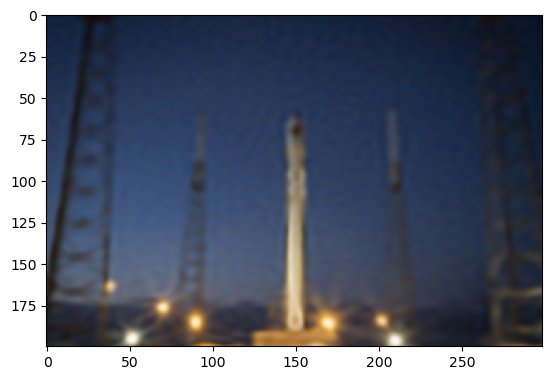

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.002067513996735215
PSNR: 74.97631921258234


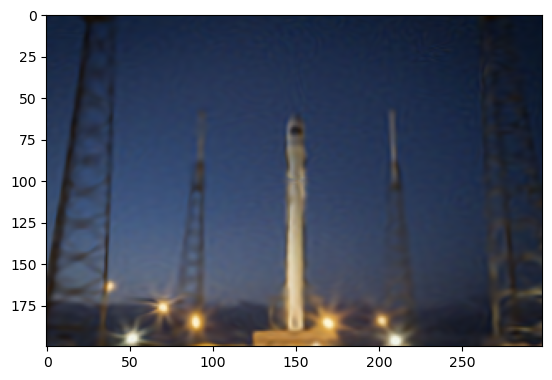

Step 1000, total loss 0.015090787783265114
PSNR: 66.34368463135681


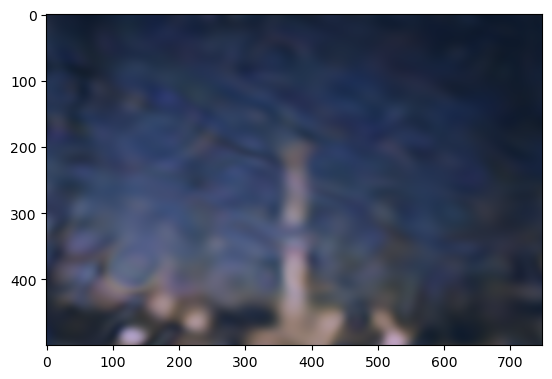

Step 1000, total loss 0.00799600686877966
PSNR: 69.10207213338944


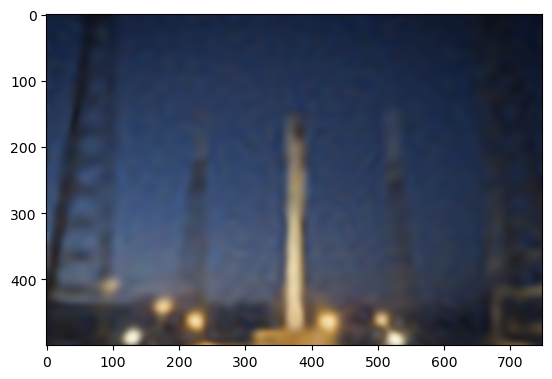

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.006304753944277763
PSNR: 70.13412254940198


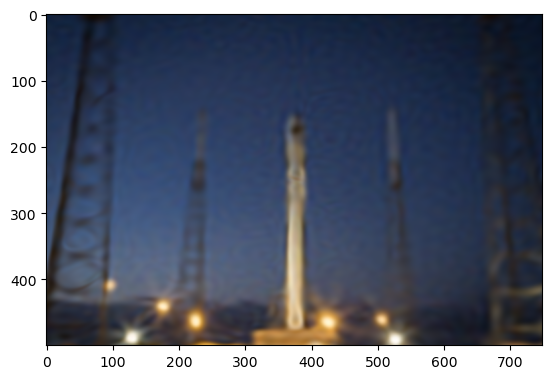

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.005176715087145567
PSNR: 70.99026113012783


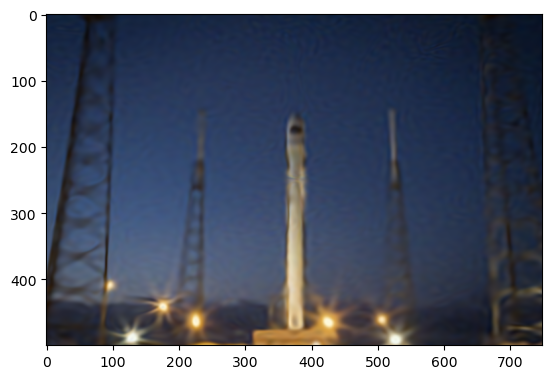

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.003600624157115817
PSNR: 72.56702576873448


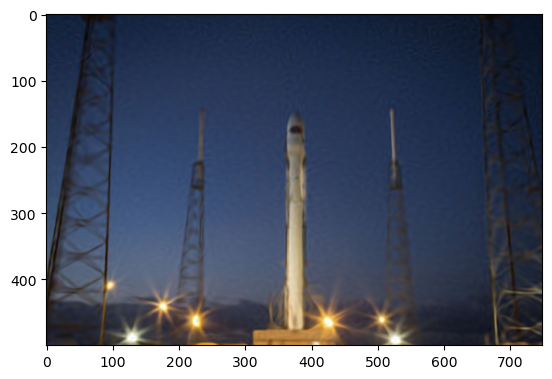

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, total loss 0.002483353717252612
PSNR: 74.18041781286233


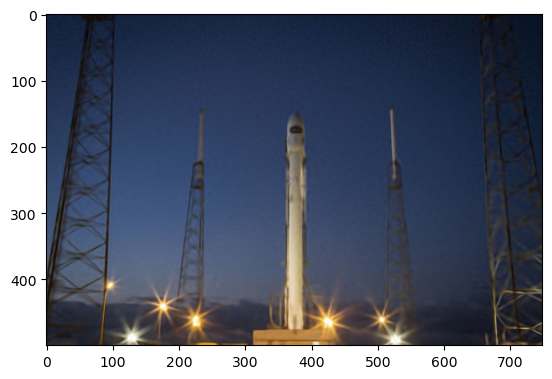

In [6]:
for size in [50, 100, 200, 500]:
    for hidden, layer in [(20, 2), (50, 2), (100, 2), (100, 3), (200, 3), (200, 4)]:
        torch.manual_seed(42)
        img = Image.fromarray(skimage.data.rocket())
        fset = Functa(img, size)
        fl = DataLoader(fset, batch_size=1, shuffle=False)
        siren = Siren(2, hidden, layer, 3).to(device)
        train(siren, fl, 1000)